# things to try:
1. add lack variable to all bytes along with difference var (e.g. byte0.shift(1) - byte0)
2. add time shift variable to timstanps
3. Try sum of bytes

# Methods:
1. STL decompostion. break TS into seasonality, trend and residuals and analyze redisuals.
2. Isolation Forest. Tree based approach that splits the data into branches. Shorter branches are created by anomalies
3. Forecasting. Predict next values and if the new ones deviates from the prediction -> anomaly
4. K-means. Create K clusters based on Elbow method. Than calculate distance to each observation. If the distance is longer than a threshold -> outlier.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDOneClassSVM
from sklearn.svm import OneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score, recall_score, precision_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

sns.set_theme()
%matplotlib inline
plt.rcParams['figure.dpi'] = 140

In [2]:
# normal attack-free messages
normal = pd.read_csv('hacker_dataset/attack_free_data.csv')
# spoofed gear message (every 1 millisecond)
gear = pd.read_csv('hacker_dataset/gear_dataset.csv')
# spoofed rpm message (every 1 millisecond)
rpm = pd.read_csv('hacker_dataset/RPM_dataset.csv')
# DoS Attack : Injecting messages of ‘0000’ CAN ID every 0.3 milliseconds. ‘0000’ is the most dominant.
dos = pd.read_csv('hacker_dataset/DoS_dataset.csv')
#Fuzzy Attack : Injecting messages of totally random CAN ID and DATA values every 0.5 milliseconds.
fuzzy = pd.read_csv('hacker_dataset/Fuzzy_dataset.csv')

# Data Preparation

In [3]:
# shift flag value to the right place for messages with DLC less than 8
def shift_flag(dataset):
    short_dlc = dataset[dataset.DLC<8]
    short_index = short_dlc.index
    dlcs = pd.unique(short_dlc.DLC)
    
    for dlc in dlcs:
        sub_short_dlc_index = short_dlc[short_dlc.DLC==dlc].index
        sub_short_dlc = short_dlc.loc[sub_short_dlc_index, :]
        
        sub_short_dlc.loc[:, ('Flag')] = sub_short_dlc.loc[:, (f'byte{dlc}')]
        sub_short_dlc.loc[:, (f'byte{dlc}')] = np.nan
        
        short_dlc.loc[sub_short_dlc_index, :] = sub_short_dlc
        
    dataset.loc[short_index, :] = short_dlc
    
    return dataset

# DoS / Fuzzy check

In [4]:
for dataset in (dos, fuzzy):
    dataset = shift_flag(dataset)

c:\projects\ML\CAN_Intrusion_Detection\ids_env\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [5]:
for dataset in (dos, fuzzy):
    t0 = dataset.Timestamp[0]
    dataset.Timestamp = dataset.Timestamp - t0

In [6]:
# substract shifted Timestamp values to get the time lapsed from the last received message
dos.Timestamp = dos.Timestamp - dos.Timestamp.shift(1)
fuzzy.Timestamp = fuzzy.Timestamp - fuzzy.Timestamp.shift(1)
# convert CAN IDs to decimal form
dos.CAN_ID = dos.CAN_ID.apply(lambda x: int(x, 16))
fuzzy.CAN_ID = fuzzy.CAN_ID.apply(lambda x: int(x, 16))

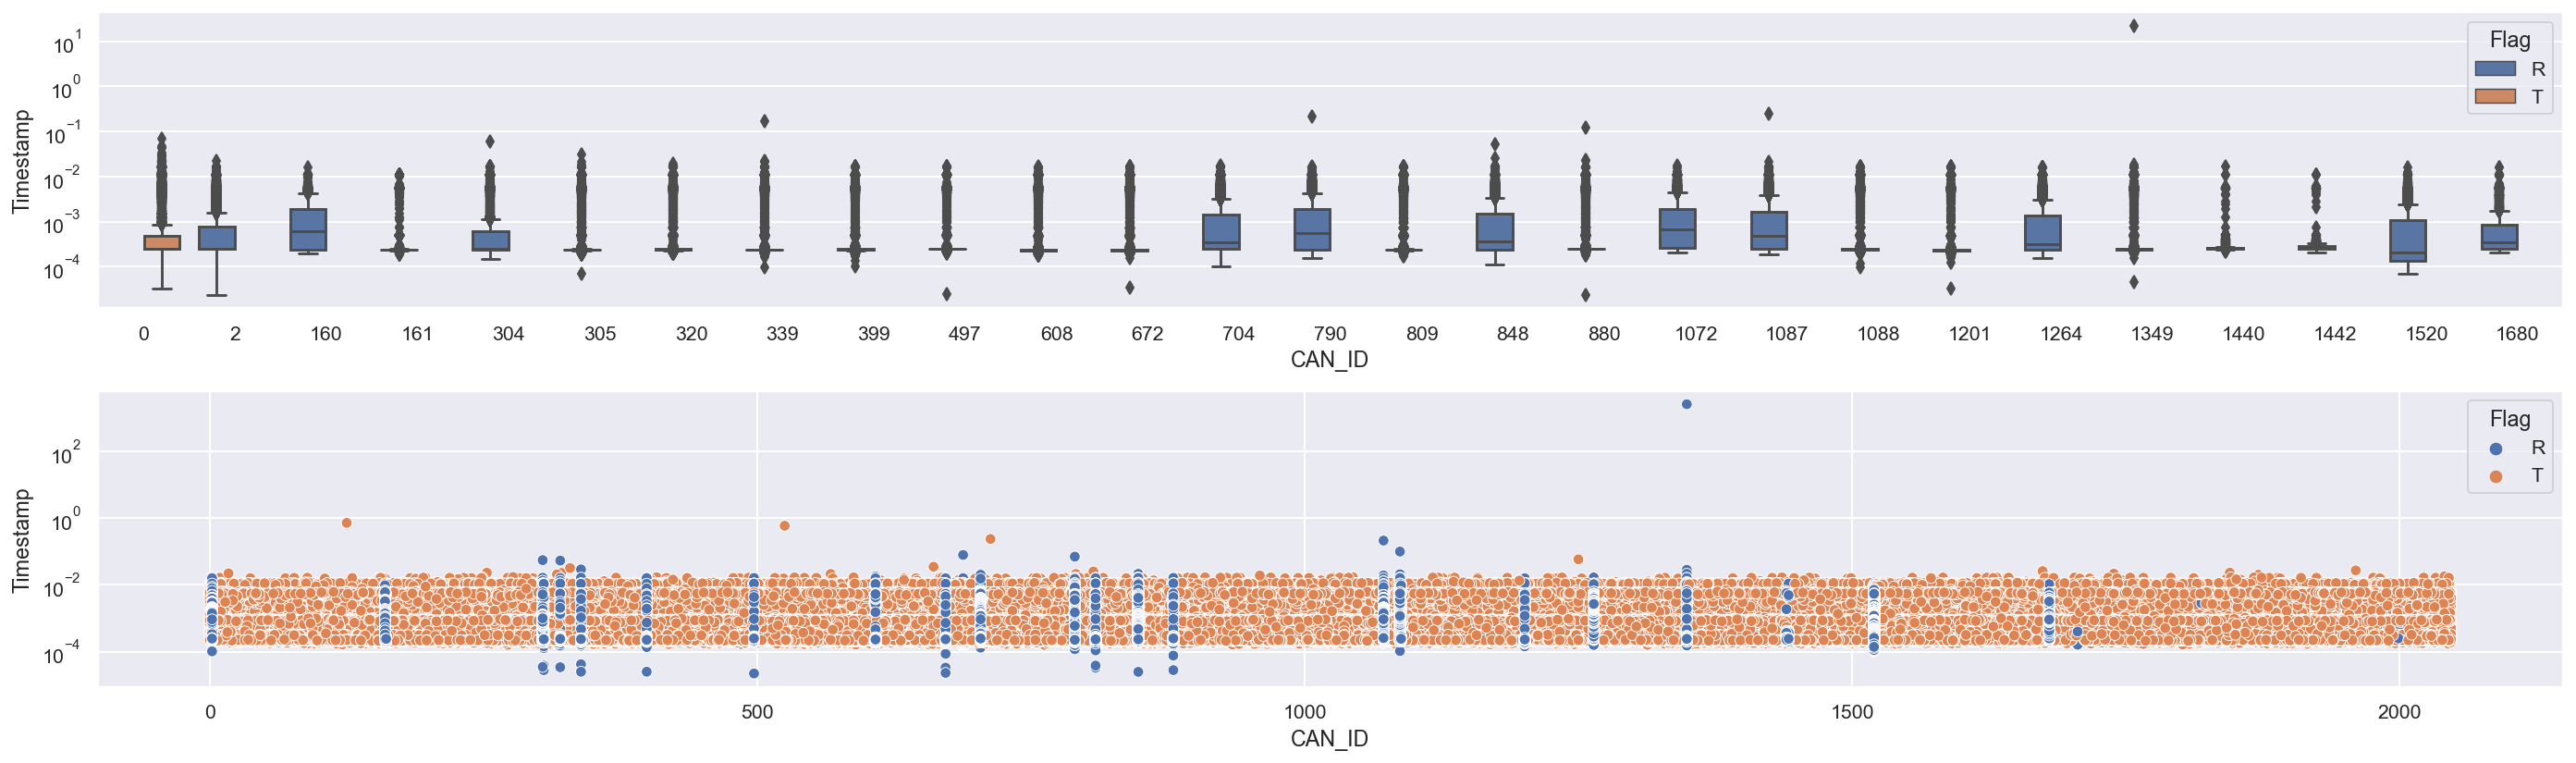

In [7]:
f, axs = plt.subplots(2, 1, figsize=(20, 6))

axs[0].set_yscale('log')
axs[1].set_yscale('log')

sns.boxplot(x=dos.CAN_ID, y=dos.Timestamp, hue=dos.Flag, ax=axs[0])
sns.scatterplot(x=fuzzy.CAN_ID, y=fuzzy.Timestamp, hue=fuzzy.Flag, ax=axs[1])

f.tight_layout()

In [8]:
# drop the first NaN observation
dos = dos.drop([0]) 
fuzzy = fuzzy.drop([0])

In [9]:
dos = dos.loc[:, ['Timestamp', 'CAN_ID', 'Flag']]
fuzzy = fuzzy.loc[:, ['Timestamp', 'CAN_ID', 'Flag']]

In [10]:
Xdos_train, Xdos_test = train_test_split(dos, test_size=.2, random_state=42, shuffle=True) 
Xfuzzy_train, Xfuzzy_test = train_test_split(fuzzy, test_size=.2, random_state=42, shuffle=True) 

In [11]:
ydos_train = Xdos_train.Flag
ydos_test = Xdos_test.Flag

Xdos_train = Xdos_train.drop('Flag', axis=1)
Xdos_test = Xdos_test.drop('Flag', axis=1)


yfuzzy_train = Xfuzzy_train.Flag
yfuzzy_test = Xfuzzy_test.Flag

Xfuzzy_train = Xfuzzy_train.drop('Flag', axis=1)
Xfuzzy_test = Xfuzzy_test.drop('Flag', axis=1)

In [12]:
print(f"Xdos_train: {Xdos_train.shape}\tXdos_test: {Xdos_test.shape}" )
print(f"ydos_train: {ydos_train.shape}\t\ttydos_test: {ydos_test.shape}" )
print('='*60)
print(f"Xfuzzy_train: {Xfuzzy_train.shape}\tXfuzzy_test: {Xfuzzy_test.shape}" )
print(f"yfuzzy_train: {yfuzzy_train.shape}\tyfuzzy_test: {yfuzzy_test.shape}" )

Xdos_train: (2932616, 2)	Xdos_test: (733154, 2)
ydos_train: (2932616,)		tydos_test: (733154,)
Xfuzzy_train: (3071087, 2)	Xfuzzy_test: (767772, 2)
yfuzzy_train: (3071087,)	yfuzzy_test: (767772,)


# Spoofing

In [13]:
# list of byte columns
byteX = ['byte0',
        'byte1',
        'byte2',
        'byte3',
        'byte4',
        'byte5',
        'byte6',
        'byte7']

## Gear/RPM Message

In [14]:
# identify the ID of the gear message
gearID = pd.unique(gear[gear.Flag=='T'].CAN_ID)[0]
rpmID = pd.unique(rpm[rpm.Flag=='T'].CAN_ID)[0]

print(f"spoofed gear message ID: {gearID}")
print(f"spoofed rpm message ID: {rpmID}")

spoofed gear message ID: 043f
spoofed rpm message ID: 0316


In [15]:
gear = gear[gear.CAN_ID==gearID]
rpm = rpm[rpm.CAN_ID==rpmID]

In [16]:
for one_byte in byteX:
    gear.loc[:, one_byte] = gear.loc[:, one_byte].apply(lambda x: int(x, 16)).astype('float')
    rpm.loc[:, one_byte] = rpm.loc[:, one_byte].apply(lambda x: int(x, 16)).astype('float')

In [17]:
gear = gear.loc[:, byteX + ['Flag']]
rpm = rpm.loc[:, byteX + ['Flag']]

In [18]:
Xgear_train, Xgear_test = train_test_split(gear, test_size=.2, shuffle=True, random_state=42)
Xrpm_train, Xrpm_test = train_test_split(rpm, test_size=.2, shuffle=True, random_state=42)

In [19]:
# Gear
ygear_train = Xgear_train.Flag
Xgear_train.drop('Flag', axis=1, inplace=True)

ygear_test = Xgear_test.Flag
Xgear_test.drop('Flag', axis=1, inplace=True)

# RPM
yrpm_train = Xrpm_train.Flag
Xrpm_train.drop('Flag', axis=1, inplace=True)

yrpm_test = Xrpm_test.Flag
Xrpm_test.drop('Flag', axis=1, inplace=True)

In [20]:
print('Gear Message:')
print(f"Xgear_train: {Xgear_train.shape}\tygear_train: {ygear_train.shape}")
print(f"Xgear_test: {Xgear_test.shape}\t\tygear_test: {ygear_test.shape}")

print('RPM Message:')
print(f"Xrpm_train: {Xrpm_train.shape}\t\tyrpm_train: {yrpm_train.shape}")
print(f"Xrpm_test: {Xrpm_test.shape}\t\tyrpm_test: {yrpm_test.shape}")

Gear Message:
Xgear_train: (643632, 8)	ygear_train: (643632,)
Xgear_test: (160909, 8)		ygear_test: (160909,)
RPM Message:
Xrpm_train: (696984, 8)		yrpm_train: (696984,)
Xrpm_test: (174247, 8)		yrpm_test: (174247,)


# Metrics

In [21]:
custom_f1 = make_scorer(f1_score, labels=['R', 'T'], pos_label='T')

In [58]:
def plot_confmat(Y_true, Y_pred):
    '''Plots confusion matrix for true/predicted values'''
    
    # total number of samples
    n = Y_true.shape[0]
    # coef to convert absolute number of samples into percentage
    coef = 100/n

    tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred, labels=['T','R']).ravel()
    cm = pd.DataFrame(
        data=[[tp*coef, fn*coef],[fp*coef, tn*coef]],
        index=['T', 'R'],
        columns=['T', 'R'])
  
    _ = plt.figure(figsize=(4,4))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='.3f',
        square=True
    )

    ax.set_title('Confusion Matrix (%)')
    ax.set_ylabel('True labels')
    ax.set_xlabel('Predicted labels')

# DoS/Fuzzy modeling

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

## Hyperparameters tuning

In [24]:
pipe_svc = Pipeline(steps=[
                            ('Nystroem', Nystroem(n_jobs=2)),
                            ('sgdSVM', SGDClassifier())])

In [25]:
params = {
    'Nystroem__n_components': [300],
    'Nystroem__gamma':np.arange(0.311, 0.321, 0.001),
    'sgdSVM__alpha': [1e-5],
}

In [26]:
#search = GridSearchCV(pipe_svc, param_grid=params, scoring=custom_f1, cv=3, verbose=3)
#search.fit(Xfuzzy_train, yfuzzy_train)

In [27]:
#print(search.best_score_)
#print(search.best_params_)

## Fuzzy SGDClassifier 

In [28]:
svc_fuzzy = Pipeline([('Nystroem', Nystroem(n_components=300,
                                            gamma=0.321)),
                    ('sgd_class', SGDClassifier(alpha=1e-6))])

In [29]:
svc_fuzzy.fit(Xfuzzy_train, yfuzzy_train)

Pipeline(steps=[('Nystroem', Nystroem(gamma=0.321, n_components=300)),
                ('sgd_class', SGDClassifier(alpha=1e-06))])

In [30]:
yfuzzy_pred = svc_fuzzy.predict(Xfuzzy_test)

In [31]:
print(f1_score(yfuzzy_test, yfuzzy_pred, labels=['T', 'R'], pos_label='T'))
print(precision_score(yfuzzy_test, yfuzzy_pred, labels=['T', 'R'], pos_label='T'))
print(recall_score(yfuzzy_test, yfuzzy_pred, labels=['T', 'R'], pos_label='T'))

0.9801684521077145
0.9910200250312892
0.9695519524912503


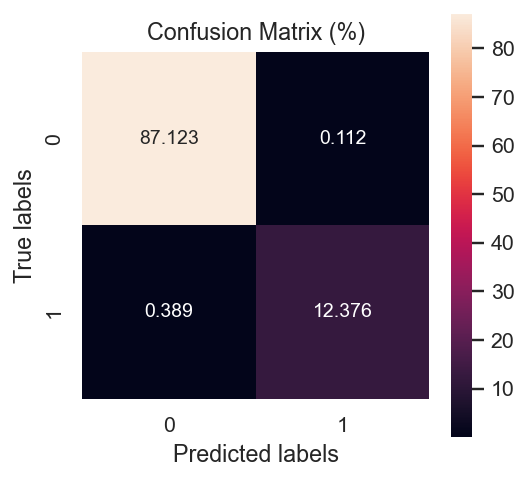

In [32]:
plot_confmat(yfuzzy_test, yfuzzy_pred)

## DoS SGDClassifier 

In [33]:
svc_dos = SGDClassifier()

In [34]:
svc_dos.fit(Xdos_train, ydos_train)
ydos_pred = svc_dos.predict(Xdos_test)

In [35]:
print(f1_score(ydos_test, ydos_pred, labels=['T', 'R'], pos_label='T'))
print(precision_score(ydos_test, ydos_pred, labels=['T', 'R'], pos_label='T'))
print(recall_score(ydos_test, ydos_pred, labels=['T', 'R'], pos_label='T'))

1.0
1.0
1.0


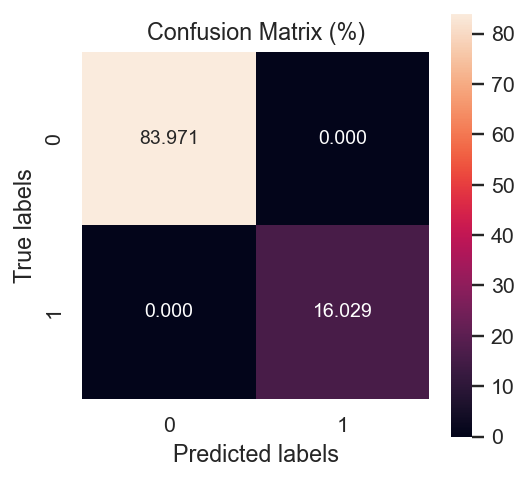

In [36]:
plot_confmat(ydos_test, ydos_pred)

# Spoofing modeling

## Gear Message

In [169]:
svc_gear = Pipeline([('Nystroem', Nystroem(gamma=0.321)),
                    ('sgd_class', SGDClassifier(alpha=1e-8))])

In [170]:
svc_gear.fit(Xgear_train, ygear_train)

Pipeline(steps=[('Nystroem', Nystroem(gamma=0.321)),
                ('sgd_class', SGDClassifier(alpha=1e-08))])

In [171]:
ygear_pred = svc_gear.predict(Xgear_test)

In [172]:
print(f1_score(ygear_test, ygear_pred, labels=['T', 'R'], pos_label='T'))
print(precision_score(ygear_test, ygear_pred, labels=['T', 'R'], pos_label='T'))
print(recall_score(ygear_test, ygear_pred, labels=['T', 'R'], pos_label='T'))

1.0
1.0
1.0


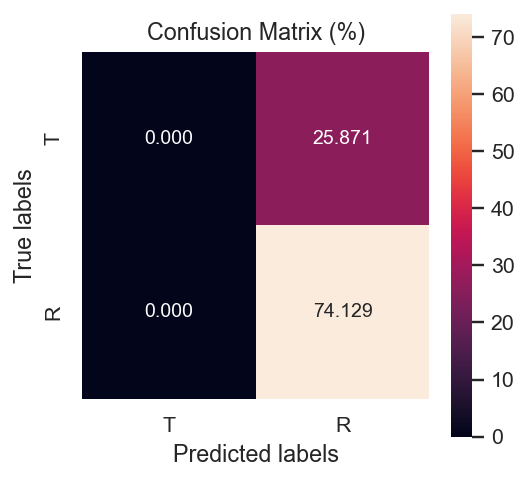

In [131]:
plot_confmat(ygear_test, ygear_pred)

## RPM Message

In [42]:
svc_rpm = SGDClassifier()           

In [43]:
svc_rpm.fit(Xrpm_train, yrpm_train)

SGDClassifier()

In [44]:
yrpm_pred = svc_rpm.predict(Xrpm_test)

In [45]:
print(f1_score(yrpm_test, yrpm_pred, labels=['T', 'R'], pos_label='T'))
print(precision_score(yrpm_test, yrpm_pred, labels=['T', 'R'], pos_label='T'))
print(recall_score(yrpm_test, yrpm_pred, labels=['T', 'R'], pos_label='T'))

1.0
1.0
1.0


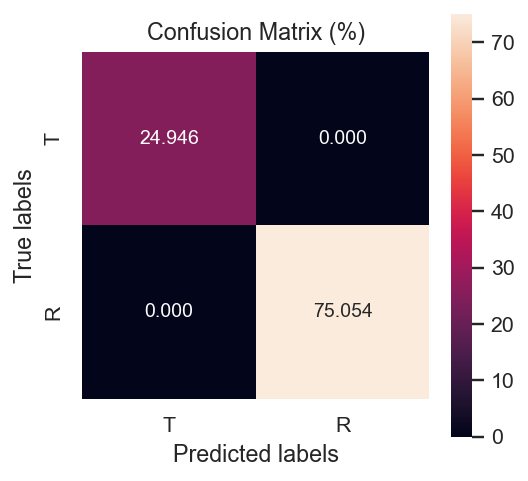

In [60]:
plot_confmat(yrpm_test, yrpm_pred)

# Check estimators on normal data

Current results (f1):
1. DoS: 1.0
2. Fuzzy: 0.9994870305747989
3. gear: 1.0
4. rpm: 1.0

In [47]:
t0 = normal.Timestamp[0]
normal.Timestamp = normal.Timestamp - t0
normal.Timestamp = normal.Timestamp - normal.Timestamp.shift(1)
normal.drop([0, 988871], axis=0, inplace=True)
normal.CAN_ID = normal.CAN_ID.apply(lambda x: int(x, 16))

In [75]:
nor_gear = normal[normal.CAN_ID==int('043f', 16)][byteX]
nor_rpm = normal[normal.CAN_ID==int('0316', 16)][byteX]

for one_byte in byteX:
    nor_gear.loc[:, one_byte] = nor_gear.loc[:, one_byte].apply(lambda x: int(x, 16)).astype('float')
    nor_rpm.loc[:, one_byte] = nor_rpm.loc[:, one_byte].apply(lambda x: int(x, 16)).astype('float')

In [173]:
#nor_dos_pred = svc_dos.predict(normal.loc[:, ['Timestamp', 'CAN_ID']])
#nor_fuzzy_pred = svc_fuzzy.predict(normal.loc[:, ['Timestamp', 'CAN_ID']])
nor_gear_pred = svc_gear.predict(nor_gear)
#nor_rpm_pred = svc_rpm.predict(nor_rpm)

f1 score: 1.0


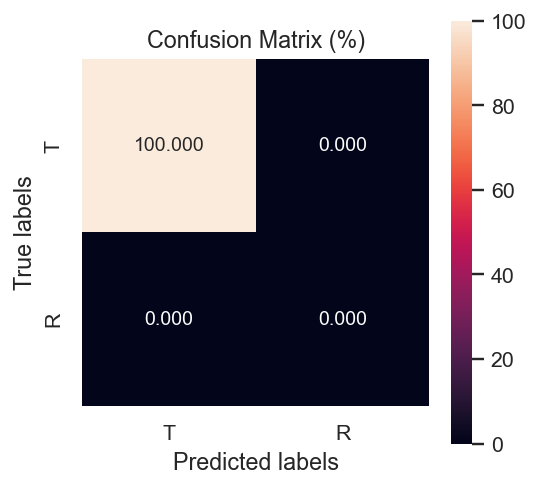

In [174]:
predicted = nor_gear_pred

ground_true = pd.Series(['R' for _ in range(predicted.shape[0])])
print(f"f1 score: {f1_score(ground_true, predicted, labels=['T', 'R'], pos_label='R')}")   
plot_confmat(ground_true, predicted)

# ++++++++++++++++++++++++++++++++++++

In [4]:
# identify the ID of the gear message
gearID = pd.unique(gear[gear.Flag=='T'].CAN_ID)[0]
print(f"spoofed gear message ID: {gearID}")

gear_norm = normal[normal.CAN_ID==gearID].reset_index(drop=True)
gear_attack = gear[gear.CAN_ID==gearID].reset_index(drop=True)


spoofed gear message ID: 043f


In [5]:
def convertToDec(df, cols):
    '''Converts hex values of df stored in cols into dec'''
    result = df.copy()
    for col in cols:
        result.loc[:, col] = result.loc[:, col].apply(lambda x: int(x, 16)).astype('float')
    return result

In [6]:
# list of byte columns
byteX = ['byte0',
        'byte1',
        'byte2',
        'byte3',
        'byte4',
        'byte5',
        'byte6',
        'byte7']

In [7]:
gear_norm = convertToDec(gear_norm, byteX)
gear_attack = convertToDec(gear_attack, byteX)

<AxesSubplot:>

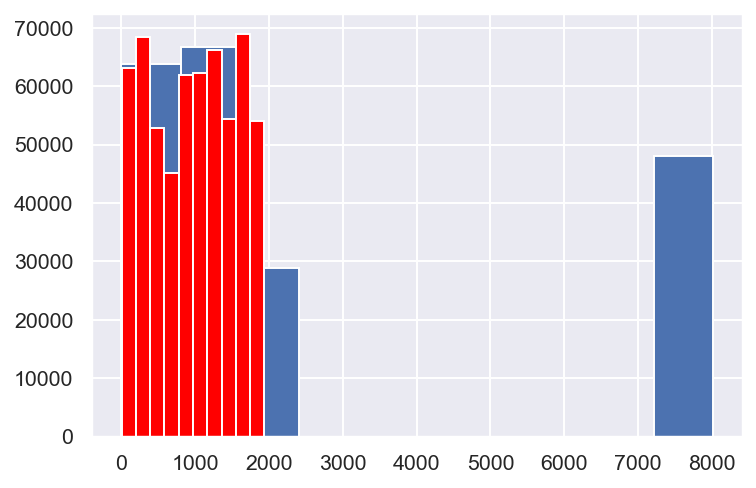

In [109]:
gear_attack[gear_attack.Flag=='R'].Timestamp.hist()
gear_attack[gear_attack.Flag=='T'].Timestamp.hist(color='red')

It seems that we have more spoofed messages in the dataset than normal ones...

# Feature engineering

## Gradient of bytes

The algorithms will work much better if we add some outliers to the training 
data. As the portion of attack messages are about 70% in the joint dataset it
makes them not so outliers. Therefore, we create our traning dataset based on 
the attack-free set with addition of some attacks to have proportion about 
95/5 % normal/attack. 

In [10]:
attack_msgs = gear_attack[gear_attack.Flag=='T']
normal_msgs = gear_attack[gear_attack.Flag=='R']

In [11]:
print(attack_msgs.shape)
print(normal_msgs.shape)

(597252, 12)
(207289, 12)


In [12]:
# percent of attack messages that needs to be sampled out of all_gear dataset
# to have proportion mentioned above (95/5 %)
perc_frac_train = 0.0042
perc_frac_test = 0.022

outliers_train = attack_msgs.sample(frac=perc_frac_train).reset_index(drop=True)
outliers_test = attack_msgs.sample(frac=perc_frac_test).reset_index(drop=True)

In [13]:
print(outliers_train.shape)
print(outliers_test.shape)

(2508, 12)
(13140, 12)


In [14]:
train = pd.concat([gear_norm, outliers_train], axis=0)
print(f"Percentage attack messages in train: {train[train.Flag=='T'].shape[0]/train.shape[0]}")
train.head(4)

Percentage attack messages in train: 0.047188093849366876


,Timestamp,CAN_ID,DLC,byte0,byte1,byte2,byte3,byte4,byte5,byte6,byte7,Flag
0,928244.798381,043f,8.0,0.0,64.0,96.0,255.0,90.0,108.0,8.0,0.0,NaN
1,928244.808409,043f,8.0,0.0,64.0,96.0,255.0,90.0,106.0,8.0,0.0,NaN
2,928244.818403,043f,8.0,0.0,64.0,96.0,255.0,90.0,106.0,8.0,0.0,NaN
3,928244.828397,043f,8.0,0.0,64.0,96.0,255.0,90.0,106.0,8.0,0.0,NaN


In [15]:
test = pd.concat([normal_msgs, outliers_test], axis=0)
print(f"Percentage attack messages in test: {test[test.Flag=='T'].shape[0]/test.shape[0]}")
test.head(4)

Percentage attack messages in test: 0.059611031216400746


,Timestamp,CAN_ID,DLC,byte0,byte1,byte2,byte3,byte4,byte5,byte6,byte7,Flag
0,0.000976,043f,8,16.0,64.0,96.0,255.0,120.0,196.0,8.0,0.0,R
1,0.009916,043f,8,16.0,64.0,96.0,255.0,120.0,195.0,8.0,0.0,R
2,0.020971,043f,8,16.0,64.0,96.0,255.0,120.0,194.0,8.0,0.0,R
3,0.030655,043f,8,16.0,64.0,96.0,255.0,120.0,194.0,8.0,0.0,R


In [16]:
# normalize values in byteX features
#train_extend.loc[:, byteX_diffX] = np.log1p(train_extend.loc[:, byteX_diffX].astype(float))
#test_gear_extend.loc[:, byteX_diffX] = np.log1p(test_gear_extend.loc[:, byteX_diffX].astype(float))

# Train/Validation/Test sets split

In [17]:
X_train = train.loc[:, byteX].sample(frac=1).reset_index(drop=True)
print(X_train.shape)
X_train.head(4)

(53149, 8)


,byte0,byte1,byte2,byte3,byte4,byte5,byte6,byte7
0,4.0,69.0,96.0,255.0,102.0,38.0,16.0,0.0
1,1.0,69.0,96.0,255.0,91.0,76.0,3.0,0.0
2,7.0,71.0,96.0,255.0,108.0,131.0,1.0,0.0
3,1.0,69.0,96.0,255.0,100.0,0.0,0.0,0.0


In [18]:
# validation set 
X_val, X_test = train_test_split(test.loc[:, byteX+['Flag']], train_size=0.5, random_state=42)

In [19]:
X_val.reset_index(drop=True, inplace=True)
print(X_val.shape)

(110214, 9)


In [20]:
X_test.reset_index(drop=True, inplace=True)
print(X_test.shape)

(110215, 9)


In [21]:
y_val = X_val.loc[:, 'Flag'].rename({'Flag': 'y_val_true'})
X_val.drop('Flag', axis=1, inplace=True)

y_test = X_test.loc[:, 'Flag'].rename({'Flag': 'y_test_true'})
X_test.drop('Flag', axis=1, inplace=True)

In [22]:
# replace 'T' and 'R' values with -1/1
y_val = y_val.replace({'T':-1, 'R':1})
y_test = y_test.replace({'T':-1, 'R':1})

In [23]:
print(f"y_train: {X_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"x_val: {X_val.shape}")
print(f"y_test: {y_test.shape}")
print(f"x_test: {X_test.shape}")

y_train: (53149, 8)
y_val: (110214,)
x_val: (110214, 8)
y_test: (110215,)
x_test: (110215, 8)


# Modeling

In [24]:
def plot_confmat(Y, Y_hat):
    '''Plots confusion matrix for true/predicted values'''
    
    # total number of samples
    n = Y.shape[0]
    # coef to convert absolute number of samples into percentage
    coef = 100/n

    tn, fp, fn, tp = confusion_matrix(Y, Y_hat, labels=[1, -1]).ravel()
    cm = pd.DataFrame(
        data=[[tp*coef, fn*coef],[fp*coef, tn*coef]],
        index=['attack', 'normal'],
        columns=['attack', 'normal'])

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    #print(f'tn: {tn}')
    #print(f'fp: {fp}')
    #print(f'fn: {fn}')
    #print(f'tp: {tp}')

    #print(cm)
    #print(f"precision : {precision}")
    #print(f"recall : {recall}")
    #print(f"f1 : {f1}")
   
    _ = plt.figure(figsize=(4,4))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='.3f',
        square=True
    )

    ax.set_title('Confusion Matrix (%)')
    ax.set_ylabel('True labels')
    ax.set_xlabel('Predicted labels')


# PCA

In [25]:
pca = PCA(n_components=2)

Xr_t = pd.DataFrame(pca.fit_transform(X_train), columns=['feat1', 'feat2'])
print(f"Variance retained for Xr_t: {pca.explained_variance_ratio_}")

Xr_v = pd.DataFrame(pca.fit_transform(X_val), columns=['feat1', 'feat2'])
print(f"Variance retained for Xr_v: {pca.explained_variance_ratio_}")

Xr_test = pd.DataFrame(pca.fit_transform(X_test), columns=['feat1', 'feat2'])
print(f"Variance retained for Xr_test: {pca.explained_variance_ratio_}")

Variance retained for Xr_t: [0.88456506 0.10376333]
Variance retained for Xr_v: [0.98999606 0.00727275]
Variance retained for Xr_test: [0.9900397  0.00725053]


<AxesSubplot:xlabel='feat1', ylabel='feat2'>

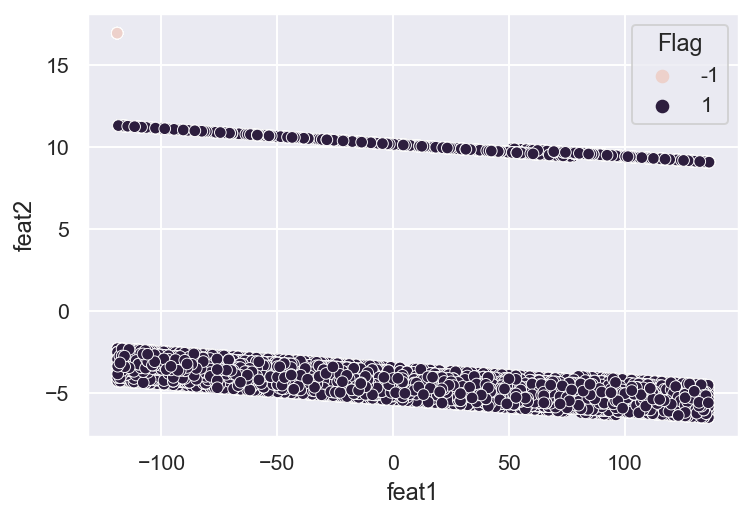

In [27]:
sns.scatterplot(x=Xr_v.feat1, y=Xr_v.feat2, hue=y_val)

In [99]:
sample = pd.concat([Xr_v, y_val], axis=1)

,feat1,feat2,Flag
0,54.997479,-5.065236,1
1,109.015464,-5.330485,1
2,-103.910486,-3.287831,1
3,21.362005,9.981167,1
4,-97.934958,-3.131385,1
...,...,...,...
110209,93.999838,-4.971642,1
110210,13.059058,-5.088989,1
110211,48.041158,-4.742569,1
110212,-22.903833,-4.956295,1


# Isolation Forest

For regular bytesX: contamination=0.041

f1 score (Validation set): 0.0


C:\Users\dred\AppData\Local\Temp/ipykernel_12684/943467236.py:17: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*(precision*recall)/(precision+recall)


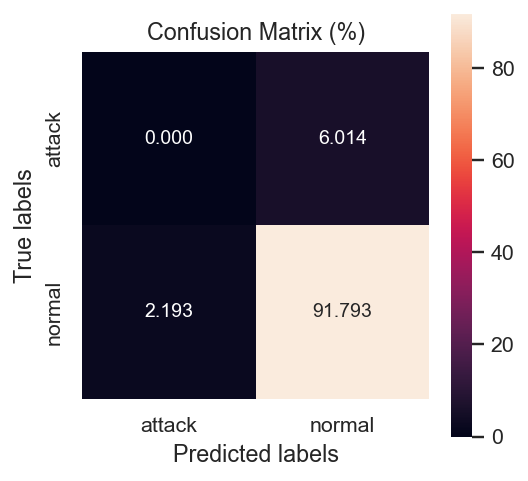

In [29]:
Iforest = IsolationForest(contamination=0.041)
Iforest.fit(Xr_t.values)
print(f"f1 score (Validation set): {f1_score(y_val, Iforest.predict(Xr_v.values), pos_label=-1)}")
plot_confmat(y_val.values, Iforest.predict(Xr_v.values))

f1 score (Test set): 0.0


C:\Users\dred\AppData\Local\Temp/ipykernel_12684/943467236.py:17: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*(precision*recall)/(precision+recall)


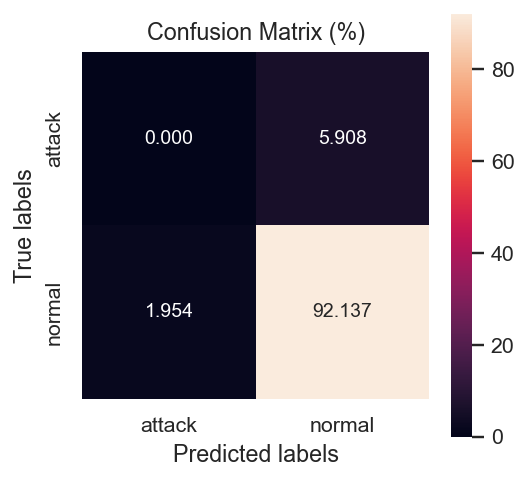

In [30]:
print(f"f1 score (Test set): {f1_score(y_test, Iforest.predict(Xr_test.values), pos_label=-1)}")
plot_confmat(y_test.values, Iforest.predict(Xr_test.values))

## SGDOneClassSVM

For regular byteX:

StandardScaler(),
    Nystroem(gamma=0.401), 
    SGDOneClassSVM(nu=0.041,
                    shuffle=True, 
                    fit_intercept=True, 
                    random_state=42,
                    tol=1e-4))

f1 score (Validation set): 0.6859153472006623


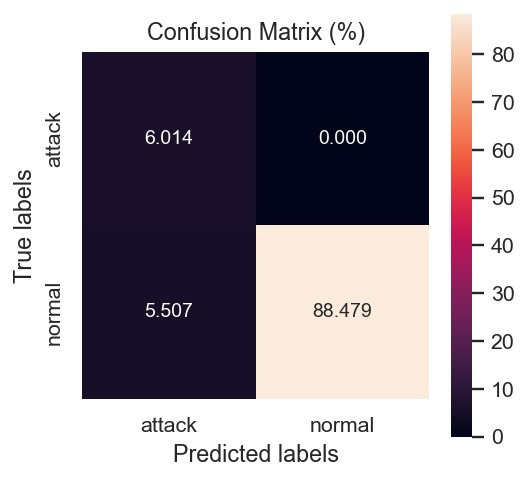

In [31]:
pipe_clf = make_pipeline(
    StandardScaler(),
    Nystroem(gamma=0.401), 
    SGDOneClassSVM(nu=0.041,
                    shuffle=True, 
                    fit_intercept=True, 
                    random_state=42,
                    tol=1e-4))

pipe_clf.fit(Xr_t)

print(f"f1 score (Validation set): {f1_score(y_val, pipe_clf.predict(Xr_v), pos_label=-1)}")
plot_confmat(y_val, pipe_clf.predict(Xr_v))

f1 score (Test set): 0.662360779128312


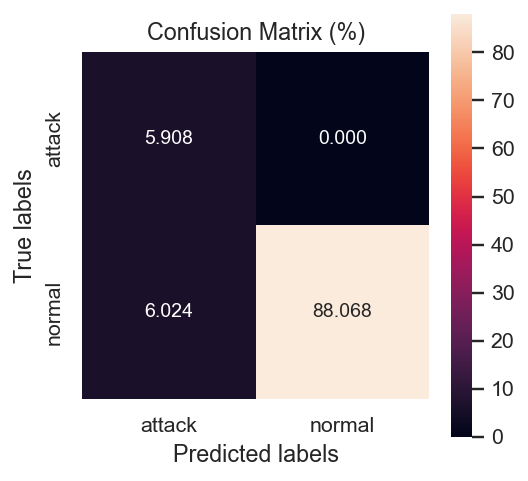

In [32]:

print(f"f1 score (Test set): {f1_score(y_test, pipe_clf.predict(Xr_test), pos_label=-1)}")
plot_confmat(y_test, pipe_clf.predict(Xr_test))